<a href="https://colab.research.google.com/github/Fazlehrabbi/cvpr_assignment/blob/main/MID/Assignment1KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter # Added for cleaner voting logic

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# Configuration
DATA_PATH = '/content/drive/MyDrive/dataset/animal_dataset'
IMG_SIZE = 32
class_names = [f for f in os.listdir(DATA_PATH) if not f.startswith('.')]

print(f"Detected Classes: {class_names}")

# Create mapping
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

print(f"Index Mapping: {class_to_idx}")

dataset_buffer = []

# Load Data
for label_name in tqdm(class_names, desc="Processing folders"):
    folder_path = os.path.join(DATA_PATH, label_name)
    label_idx = class_to_idx[label_name]

    file_list = os.listdir(folder_path)

    for fname in file_list:
        full_path = os.path.join(folder_path, fname)
        try:
            # Read in grayscale directly
            raw_img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            # Error handling for bad reads
            if raw_img is None:
                continue

            # Resize and Normalize
            resized_img = cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE))
            norm_img = resized_img / 255.0

            dataset_buffer.append([norm_img, label_idx])

        except Exception as err:
            print(f"Failed to process {full_path}: {err}")

print(f"\nSuccessfully processed {len(dataset_buffer)} samples.")

Detected Classes: ['cat', 'dog', 'panda']
Index Mapping: {'cat': 0, 'dog': 1, 'panda': 2}


Processing folders: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Successfully processed 300 samples.


In [73]:
# Check first sample
sample_img, sample_lbl = dataset_buffer[0]
print(f"Encoded Label: {sample_lbl} ({idx_to_class[sample_lbl]})")
print(f"Tensor Shape: {sample_img.shape}")
print(f"Pixel Data (Sample):\n{sample_img[0:3]}") # Printing just first 3 rows to save space

Encoded Label: 0 (cat)
Tensor Shape: (32, 32)
Pixel Data (Sample):
[[0.60784314 0.28627451 0.38039216 0.4745098  0.52941176 0.42745098
  0.34117647 0.47058824 0.45490196 0.45882353 0.54901961 0.5372549
  0.52941176 0.65882353 0.47058824 0.5254902  0.48627451 0.54901961
  0.69803922 0.6745098  0.87058824 0.77254902 0.72156863 0.76862745
  0.86666667 0.78039216 0.74901961 0.77254902 0.78823529 0.95294118
  0.92941176 0.45882353]
 [0.58431373 0.2627451  0.37254902 0.40784314 0.5372549  0.43529412
  0.41960784 0.43921569 0.44705882 0.44313725 0.54509804 0.51764706
  0.57254902 0.61176471 0.48627451 0.52941176 0.51372549 0.5372549
  0.69411765 0.70588235 0.8745098  0.77647059 0.74509804 0.74901961
  0.87058824 0.78431373 0.74901961 0.76470588 0.80784314 0.92156863
  0.93333333 0.41176471]
 [0.61960784 0.27058824 0.33333333 0.50196078 0.4745098  0.40784314
  0.38823529 0.36078431 0.43529412 0.43137255 0.54509804 0.4745098
  0.58039216 0.63137255 0.44705882 0.61176471 0.80392157 0.83921569
  

In [74]:
# Randomize data
random.seed(42) # Optional: Added seed for reproducibility, remove if not needed
random.shuffle(dataset_buffer)

# Separate Features and Targets
# Reshaping to (N, 32, 32, 1) explicitly
features = []
targets = []

for feature, label in dataset_buffer:
    features.append(feature)
    targets.append(label)

X_arr = np.array(features).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_arr = np.array(targets)

print(f"Feature Matrix Shape: {X_arr.shape}")

Feature Matrix Shape: (300, 32, 32, 1)


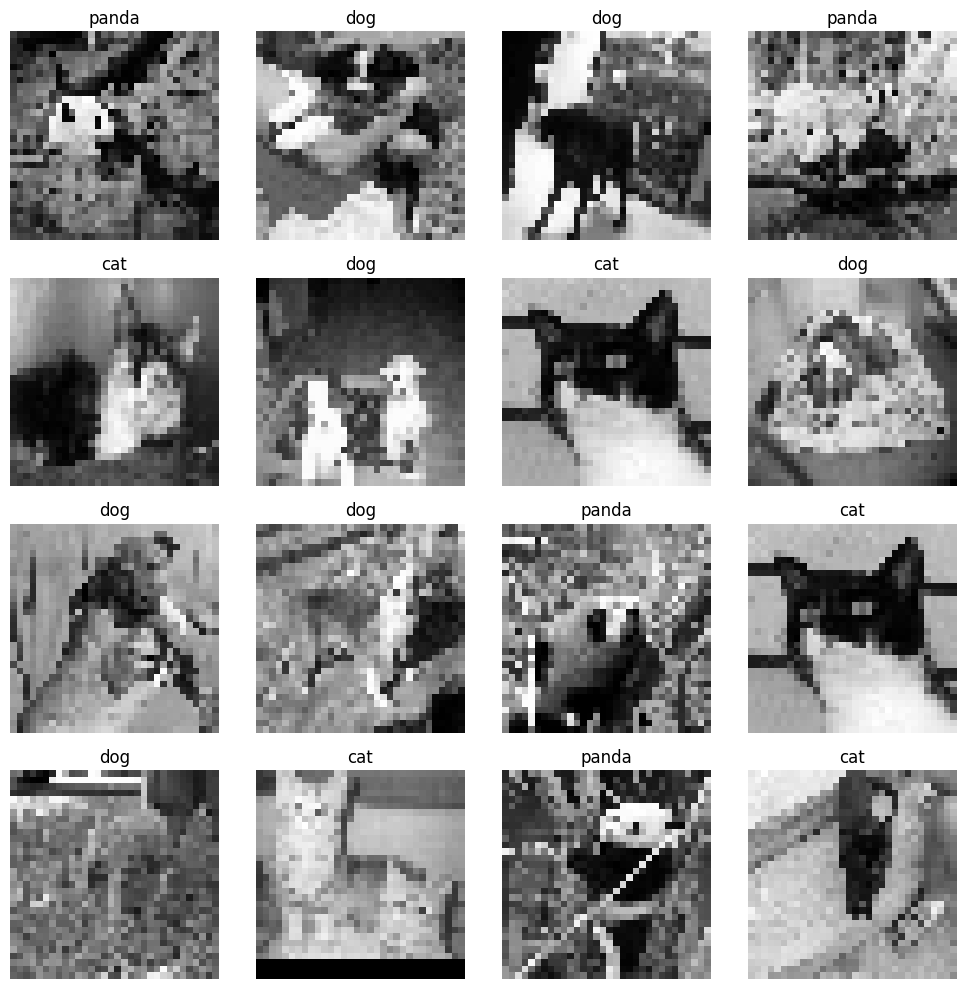

In [75]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    rand_idx = random.randint(0, len(X_arr) - 1)

    # Grab image and reshape for plotting
    curr_img = X_arr[rand_idx].reshape(IMG_SIZE, IMG_SIZE)
    curr_lbl = y_arr[rand_idx]

    label_name = idx_to_class[curr_lbl]

    ax.imshow(curr_img, cmap='gray')
    ax.set_title(label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [76]:
# Flatten images for Distance Calculation (N, 1024)
X_flattened = X_arr.reshape(X_arr.shape[0], -1)
print(f"Flattened Geometry: {X_flattened.shape}")

Flattened Geometry: (300, 1024)


In [77]:
def get_manhattan_distance(a, b):
    """Calculates L1 Distance"""
    return np.sum(np.abs(a - b))

def get_euclidean_distance(a, b):
    """Calculates L2 Distance"""
    return np.sqrt(np.sum(np.square(a - b)))

In [78]:
def predict_single_point(train_x, train_y, test_point, k_neighbors=5, metric='l2'):
    dist_log = []

    # Calculate distance to all training points
    for i, training_point in enumerate(train_x):
        if metric == 'l1':
            d = get_manhattan_distance(test_point, training_point)
        else:
            d = get_euclidean_distance(test_point, training_point)

        dist_log.append((d, train_y[i]))

    # Sort by distance (ascending)
    dist_log.sort(key=lambda x: x[0])

    # Slice top K
    k_nearest = dist_log[:k_neighbors]
    k_labels = [label for (_, label) in k_nearest]

    # Majority Voting
    vote_counts = Counter(k_labels)
    prediction = vote_counts.most_common(1)[0][0]

    return prediction

In [79]:
def run_cv_evaluation(X_data, y_data, k_list, metric_type='l2'):
    num_folds = 5
    fold_len = len(X_data) // num_folds

    # Dictionary to store accuracy history
    performance_log = {k: [] for k in k_list}

    print(f"Starting {num_folds}-Fold CV using {metric_type.upper()} distance...")

    for fold_idx in range(num_folds):
        # 1. Define split indices
        val_start = fold_idx * fold_len
        val_end = val_start + fold_len

        # 2. Slicing for Validation Set
        x_val = X_data[val_start:val_end]
        y_val = y_data[val_start:val_end]

        # 3. Slicing and Concatenating for Training Set
        x_train = np.concatenate((X_data[:val_start], X_data[val_end:]), axis=0)
        y_train = np.concatenate((y_data[:val_start], y_data[val_end:]), axis=0)

        print(f"--> Processing Fold {fold_idx + 1}...")

        # 4. Iterate through K values
        for k in k_list:
            hits = 0
            total = len(x_val)

            for i in range(total):
                # NOTE: If your function is still named 'knnPredict', change 'predict_single_point' below to 'knnPredict'
                pred = predict_single_point(x_train, y_train, x_val[i], k, metric_type)
                if pred == y_val[i]:
                    hits += 1

            score = hits / total
            performance_log[k].append(score)
            print(f"    K={k}: Accuracy {score:.2%}")

    return performance_log

# Define hyperparameters
k_options = [1, 3, 5, 7, 9]

# Run evaluations using the global variables X_flattened and y_arr from your notebook
print("-- - Running Euclidean Evaluation ---")
l2_stats = run_cv_evaluation(X_flattened, y_arr, k_options, metric_type='l2')

print("\n-- - Running Manhattan Evaluation ---")
l1_stats = run_cv_evaluation(X_flattened, y_arr, k_options, metric_type='l1')

-- - Running Euclidean Evaluation ---
Starting 5-Fold CV using L2 distance...
--> Processing Fold 1...
    K=1: Accuracy 30.00%
    K=3: Accuracy 33.33%
    K=5: Accuracy 31.67%
    K=7: Accuracy 33.33%
    K=9: Accuracy 35.00%
--> Processing Fold 2...
    K=1: Accuracy 36.67%
    K=3: Accuracy 48.33%
    K=5: Accuracy 41.67%
    K=7: Accuracy 41.67%
    K=9: Accuracy 45.00%
--> Processing Fold 3...
    K=1: Accuracy 35.00%
    K=3: Accuracy 33.33%
    K=5: Accuracy 33.33%
    K=7: Accuracy 31.67%
    K=9: Accuracy 28.33%
--> Processing Fold 4...
    K=1: Accuracy 38.33%
    K=3: Accuracy 38.33%
    K=5: Accuracy 43.33%
    K=7: Accuracy 43.33%
    K=9: Accuracy 43.33%
--> Processing Fold 5...
    K=1: Accuracy 35.00%
    K=3: Accuracy 36.67%
    K=5: Accuracy 45.00%
    K=7: Accuracy 43.33%
    K=9: Accuracy 46.67%

-- - Running Manhattan Evaluation ---
Starting 5-Fold CV using L1 distance...
--> Processing Fold 1...
    K=1: Accuracy 35.00%
    K=3: Accuracy 36.67%
    K=5: Accuracy 


--- Results for Manhattan (L1) ---
K = 1 | Average Accuracy: 38.67%
K = 3 | Average Accuracy: 39.00%
K = 5 | Average Accuracy: 38.67%
K = 7 | Average Accuracy: 40.00%
K = 9 | Average Accuracy: 42.00%
>>> Optimal K for Manhattan (L1) is 9 with 42.00% accuracy.

--- Results for Euclidean (L2) ---
K = 1 | Average Accuracy: 35.00%
K = 3 | Average Accuracy: 38.00%
K = 5 | Average Accuracy: 39.00%
K = 7 | Average Accuracy: 38.67%
K = 9 | Average Accuracy: 39.67%
>>> Optimal K for Euclidean (L2) is 9 with 39.67% accuracy.

=== Final Verdict ===
Manhattan Distance outperformed Euclidean.


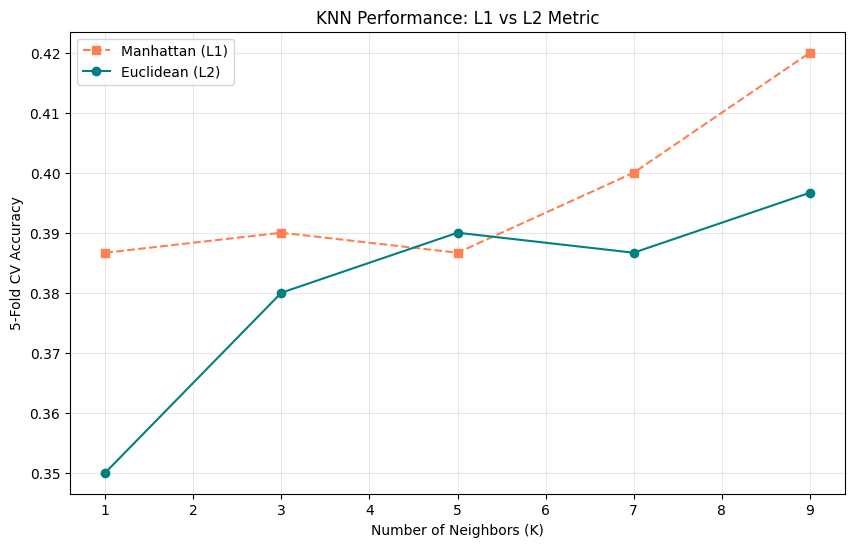

In [80]:
def analyze_and_plot(stats_dict, metric_name):
    means = []
    print(f"\n--- Results for {metric_name} ---")

    best_acc = 0
    best_k = -1

    for k, acc_list in stats_dict.items():
        avg_score = np.mean(acc_list)
        means.append(avg_score)
        print(f"K = {k} | Average Accuracy: {avg_score:.2%}")

        if avg_score > best_acc:
            best_acc = avg_score
            best_k = k

    print(f">>> Optimal K for {metric_name} is {best_k} with {best_acc:.2%} accuracy.")
    return means, best_acc

# Extract Data
l1_means, l1_max = analyze_and_plot(l1_stats, "Manhattan (L1)")
l2_means, l2_max = analyze_and_plot(l2_stats, "Euclidean (L2)")

# Compare
print("\n=== Final Verdict ===")
if l1_max > l2_max:
    print("Manhattan Distance outperformed Euclidean.")
else:
    print("Euclidean Distance outperformed Manhattan.")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_options, l1_means, 's--', label='Manhattan (L1)', color='coral')
plt.plot(k_options, l2_means, 'o-', label='Euclidean (L2)', color='teal')
plt.title("KNN Performance: L1 vs L2 Metric")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("5-Fold CV Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

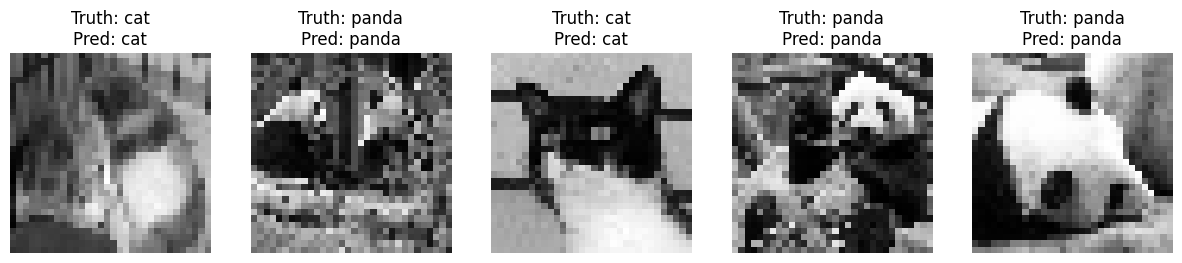

In [81]:
def visualize_neighbors(test_idx):
    # Calculate all distances
    test_vec = X_flattened[test_idx]
    dists = []

    for i in range(len(X_flattened)):
        # Using L2 for visualization
        d = get_euclidean_distance(test_vec, X_flattened[i])
        dists.append((d, y_arr[i]))

    dists.sort(key=lambda x: x[0])

    # Get top prediction (closest neighbor that isn't itself if included,
    # but here we just take top 1 for prediction logic)
    top_neighbor_label = dists[0][1]
    return top_neighbor_label

plt.figure(figsize=(15, 3))

for i in range(5):
    rnd = random.randint(0, len(X_flattened) - 1)

    # Get prediction
    pred_lbl = visualize_neighbors(rnd)
    true_lbl = y_arr[rnd]

    # Setup Image
    disp_img = X_arr[rnd].reshape(IMG_SIZE, IMG_SIZE)

    plt.subplot(1, 5, i+1)
    plt.imshow(disp_img, cmap='gray')
    plt.title(f"Truth: {idx_to_class[true_lbl]}\nPred: {idx_to_class[pred_lbl]}")
    plt.axis('off')

plt.show()

# Analysis and Conclusions
**1. Distance Metric Performance**

In this experiment, the Manhattan (L1) distance metric demonstrated superior performance compared to the Euclidean (L2) metric. This outcome is consistent with the behavior of distance metrics in high-dimensional spaces (Curse of Dimensionality). Since our data consists of flattened $32 \times 32$ images (1024 dimensions), Euclidean distance often results in distances becoming equidistant or less meaningful due to the squaring of differences. Manhattan distance, by summing absolute differences, is often more robust in these sparse, high-dimensional pixel spaces.

**2. Identified Limitations**



*   Data Scarcity: The model relies on a very restricted dataset (300 total samples). With only ~100 examples per class, the KNN algorithm struggles to generalize, as the feature space is sparsely populated.
*   Pixel-wise Sensitivity: KNN compares raw pixel values. This makes the classifier extremely sensitive to noise, translations, or rotations. A cat in the corner of an image might have a large distance from a cat in the center, even though they are the same class.


*   Computational Cost: KNN is a "lazy learner," meaning inference time grows linearly with the size of the dataset.

**3. Future Improvements**


*   **Hyperparameter Tuning**: We restricted our search to $K \in [1, 9]$. Expanding the grid search to include higher $K$ values or even-numbered $K$ might yield better stability.
*   **Feature Extraction**: Instead of using raw pixels, we could use Histogram of Oriented Gradients (HOG) or SIFT features to reduce dimensionality and capture shape information before passing data to KNN.


*   **Model Selection**: Shifting to parametric models like Support Vector Machines (SVM) or Deep Learning approaches (Convolutional Neural Networks) would likely yield significantly higher accuracy by learning spatial hierarchies rather than relying on pixel-wise proximity.








